In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import XXPlusYYGate
from qiskit.opflow import I, Z, X, Y
import numpy as np
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import CPhaseGate
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.providers.basicaer import QasmSimulatorPy  

from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler as Aer_Sam
from qiskit.compiler import transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.primitives import BackendSampler
from qiskit.providers.fake_provider import FakeCairoV2
from qiskit.providers.fake_provider import FakeNairobiV2
from qiskit.circuit.library import XXPlusYYGate
from qiskit.primitives import Estimator

C:\Users\pop75\AppData\Local\Temp\ipykernel_1448\2337547826.py:4: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import I, Z, X, Y
C:\Users\pop75\AppData\Local\Temp\ipykernel_1448\2337547826.py:8: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import VQE


In [2]:
estimator = Estimator()

In [3]:
#Adjacency matrix to dictionary
def mat_to_dict(matrix):
  '''
    matrix를 받아서, {vertex : 인접한 다른 vertex list} dict 생성
  '''
  size = len(matrix)
  result = defaultdict(list)
  for i, adj_vec in enumerate(matrix):
    for j in range(size): 
      if adj_vec[j] == 1:
        result[i].append(j)
  return result

def make_edge_numbers(matrix):
  '''
    matrix를 받아서, edge number dict 생성
  '''
  size = len(matrix)
  result = defaultdict(list)
  count = 0
  for i in range(size):
    for j in range(i, size):
      if matrix[i][j] == 1:
        result[count] = [i, j]
        count += 1
  return result

def vertex_edges(matrix):
  '''
    matrix를 받아서, {vertex : 해당 vertex에 연결된 edge number} dict 생성
  '''
  size = len(matrix)
  result = defaultdict(list)
  edges = make_edge_numbers(matrix)
  for i in range(size):
    for e in edges:
      if i in edges[e]:
        result[i].append(e)
  return result

#cost function of graph dictionary
def max_dic(dic):
  max1 = 0
  for i in dic.values():
    for j in i:
      if max1<j:
        max1=j
  return max1+1


def cost_f(dic):
    visited = []
    max1 = max_dic(dic)
      
    #print('in cost_f, dict :', dict)
    ham = 0
    for i in range(len(dic)):
      temp = 0
      for j in dic[i]:
        if j ==0:
          Ham_temp = Z
        else:
          Ham_temp = I
        for k in range(1,max1):
          if j==k:
            Ham_temp = Z^Ham_temp
          else:
            Ham_temp = I^Ham_temp
        temp += ((Ham_temp)-(I^max1))/2
      temp += 2*(I^max1)
      ham += (temp.adjoint())@(temp)
    return ham.reduce()



In [4]:
import numpy as np
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import algorithm_globals
from collections import defaultdict
matrix6 = [
    [0, 1, 0, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 1, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 1],
    [0, 1, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 0, 0, 1, 0]
]


temp = vertex_edges(matrix6)

temp = vertex_edges(matrix6)
Q_num = max_dic(temp)
qc = QuantumCircuit(Q_num)
## ansatz
P_num = Q_num**2
Parameters = ParameterVector('theta',P_num)
temp_list = []
for k in range(0,len(temp)):
    qc.x(k)
index = 0
for j in range(len(temp)):
    for i in range(Q_num-len(temp)):
        qc.append(XXPlusYYGate(Parameters[index]),[j,i+len(temp)])
        index+=1
# we will iterate over these different optimizers
##optimizers = [COBYLA(maxiter=150), L_BFGS_B(maxiter=150), SLSQP(maxiter=150)]

optimizers = [L_BFGS_B(maxiter=150)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 25

    counts = []
    values = []
    Parameters = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        Parameters.append(parameters)
    vqe = VQE(estimator, qc, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=cost_f(temp))
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete      ");

Optimization complete      


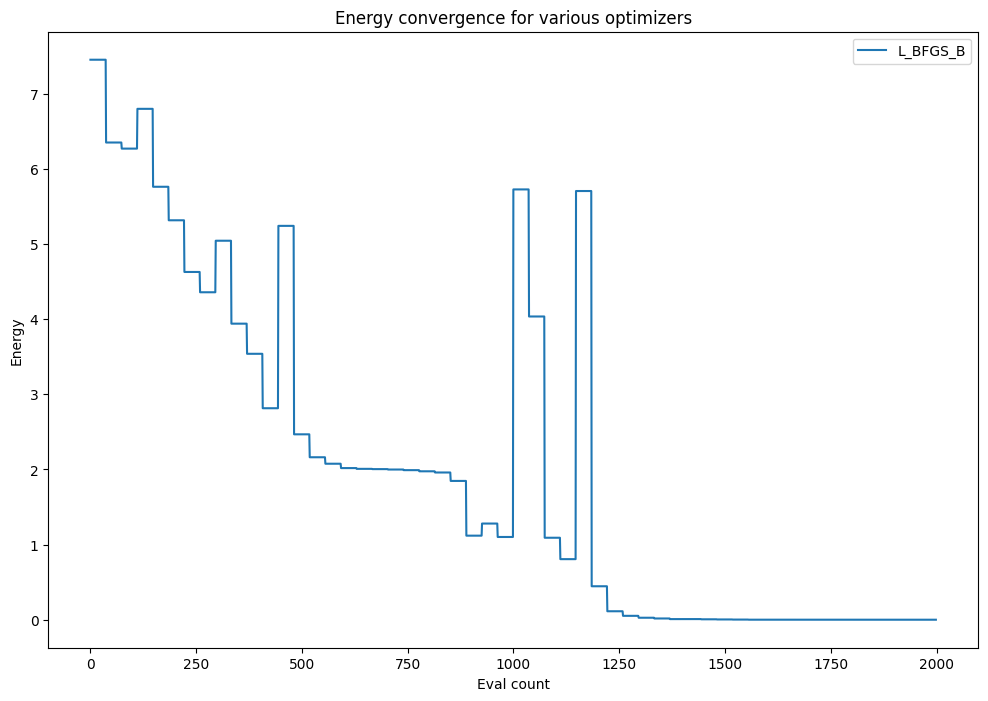

In [5]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

In [6]:
index = 0
for i in qc.parameters:
    qc = qc.bind_parameters({i:Parameters[-1][index]})
    index+=1
from qiskit import QuantumCircuit, transpile, assemble, Aer
simulator = Aer.get_backend('statevector_simulator')

# 양자 회로 시뮬레이션
job = assemble(transpile(qc.decompose()))
result = simulator.run(qc.decompose()).result()
statevector = result.get_statevector()
res = statevector.sample_counts(shots=10000)

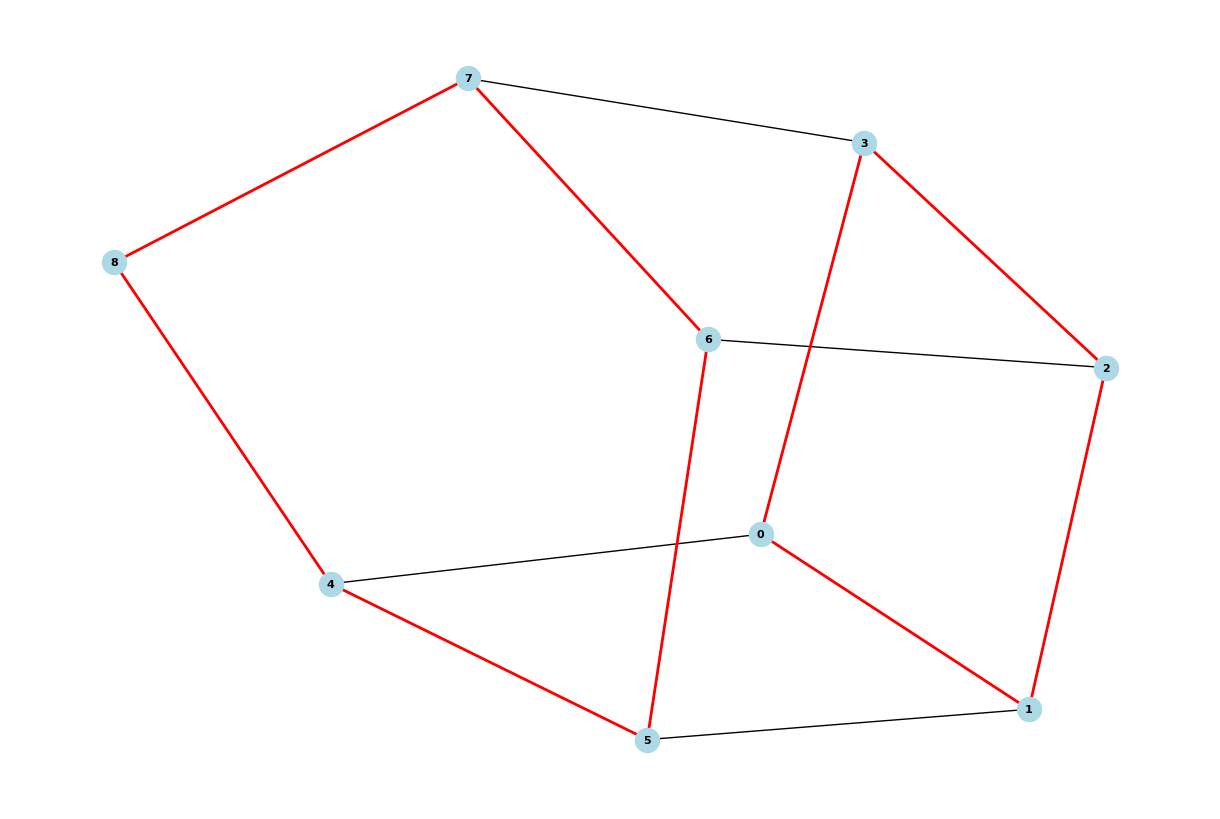

In [7]:
import networkx as nx
import matplotlib.pyplot as plt


# 그래프 생성
G = nx.Graph()
edge_dic = make_edge_numbers(matrix6)
# 정점 추가
for i in range(len(matrix6)):
    G.add_node(i)

# 엣지 추가
for i in range(len(matrix6)):
    for j in range(i + 1, len(matrix6)):
        if matrix6[i][j] == 1:
            G.add_edge(i, j)

# 그래프 그리기
pos = nx.spring_layout(G)  # 정점 위치 계산
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightblue', font_size=8)
for i in res.keys():
    tmp = i
index = -1

edge_list = []
for i in range(len(tmp)):
    if tmp[index] == '1':
        edge_list.append(edge_dic[-(index+1)])
    index -=1
# Hamiltonian Path 그리기
hamiltonian_edges = [(i[0],i[1]) for i in edge_list]
nx.draw_networkx_edges(G, pos, edgelist=hamiltonian_edges, edge_color='red', width=2)
